# Group Project - Twitter Emoji Prediction Project

- All members use shared preprocessing (same `X_train`, `y_train`)
- Each member adds their own model section below
- At the end, we will compare performance of all models

Please don’t edit other members' sections. Add your own below with your name.

# Twitter Emoji Prediction Project

This project aims to build a deep learning model to predict the most appropriate emoji for a tweet. We will explore multiple model architectures including LSTM, BiLSTM, GRU, and Transformers. This is a group project where each member implements one model and compares the results.



## Step 1: Setup & Project Overview

Dataset: [Twitter Emoji Prediction on Kaggle](https://www.kaggle.com/datasets/hariharasudhanas/twitter-emoji-prediction)

Check if GPU is present

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

## Step 2: Load and Explore the Dataset
We begin by loading the dataset and examining its structure, class balance, and sample text.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  70000 non-null  int64 
 1   TEXT        70000 non-null  object
 2   Label       70000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ MB
None
Train Duplicates: 0
Train na:  Unnamed: 0    0
TEXT          0
Label         0
dtype: int64


<Axes: xlabel='label'>

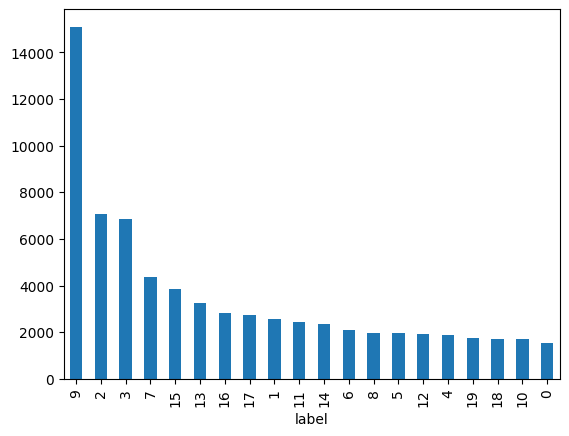

In [ ]:
df = pd.read_csv("Train.csv")

print(df.info())
print("Train Duplicates:", df.duplicated().sum())
print("Train na: ", df.isna().sum())

df.columns = ["id", "text", "label"]
df['label'].value_counts().plot(kind='bar')


New value counts after cutting label 9 by half:


<Axes: xlabel='label'>

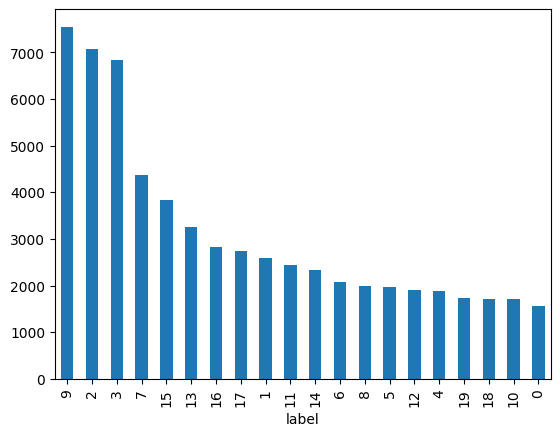

In [ ]:
label_9_df = df[df['label'] == 9]
num_to_keep = len(label_9_df) // 2

# Randomly select rows to keep
rows_to_keep = label_9_df.sample(n=num_to_keep, random_state=42) # Using a fixed random_state for reproducibility

train_df_no_label_9 = df[df['label'] != 9]
df = pd.concat([train_df_no_label_9, rows_to_keep])

print("New value counts after cutting label 9 by half:")
df['label'].value_counts().plot(kind='bar')

## Step 3: Data Preprocessing
We clean the tweet text, remove unwanted characters, tokenize the text, and pad sequences so they are the same length. We also convert labels into NumPy arrays for model input.

- Cleaning the text (e.g., remove mentions, punctuation, etc.)

- Tokenizing the text

- Padding sequences

- Converting labels to NumPy arrays (already encoded as numbers our dataset)


In [ ]:
import re

# Text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)  # remove links, mentions, hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)     # remove non-alphanumericss
    return text.lower().strip()

df['clean_text'] = df['text'].apply(clean_text)

X = df['clean_text']
y = df['label']

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

max_len = 50
vocab_size = 40000

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Padding
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Prepare inputs and labels
X = padded_sequences
y = np.array(df['label'])


In [ ]:
word_index = tokenizer.word_index
oov_count = sum(1 for text in X_train if 1 in text)  # Token '1' is <OOV>
print(f"OOV ratio: {oov_count / len(X_train):.2%}")

OOV ratio: 5.61%


In [ ]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

## Step 4: Train-Test Split
We split the data into training and testing sets. The model will learn from the training set and be evaluated on the test set.


In [ ]:
from sklearn.model_selection import train_test_split

# X is your padded_sequences; y is your label column
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))


Training samples: 56208
Test samples: 6246


## Step 5: Model Training


In [ ]:
vocab_size = 20000
max_len = 100

vectorizer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=max_len)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-05-24 05:51:29--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-24 05:51:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.33MB/s    in 2m 45s  

2025-05-24 05:54:14 (5.00 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 16436 words (3564 misses)


In [ ]:
hits = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f"Coverage: {hits} / {embedding_matrix.shape[0]} ({hits / embedding_matrix.shape[0]:.2%})")


Coverage: 16436 / 20002 (82.17%)


In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### a: Deep LSTM Model

#### Model Building
We build a deep LSTM model with embedding, stacked LSTM layers, dropout for regularization, and a dense softmax output for multi-class classification. This is the first of several models our group will test and compare.

create a deep LSTM model using TensorFlow/Keras with multiple layers

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define parameters
vocab_size = 10000       # should match tokenizer
embedding_dim = 64
max_len = 50             # should match padding
num_classes = len(np.unique(y))  # number of emoji classes

# Deep LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2
)


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.1135 - loss: 2.8775 - val_accuracy: 0.1204 - val_loss: 2.8585
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.1173 - loss: 2.8517 - val_accuracy: 0.1204 - val_loss: 2.8584
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1211 - loss: 2.8538 - val_accuracy: 0.1075 - val_loss: 2.8544
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.1196 - loss: 2.8533 - val_accuracy: 0.1204 - val_loss: 2.8556
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1178 - loss: 2.8522 - val_accuracy: 0.1204 - val_loss: 2.8537
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.1194 - loss: 2.8513 - val_accuracy: 0.1204 - val_loss: 2.8550
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.1210 - loss: 2.8495 - val_accuracy: 0.1204 - val_loss: 2.8533
Epoch 8/50


KeyboardInterrupt: 

#### Evaluation
We evaluate our deep LSTM model on the unseen test set to check its generalization ability. We also visualize training and validation accuracy/loss.


In [ ]:
# Evaluate on test set

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


438/438 [==============================] - 11s 23ms/step - loss: 2.7357 - accuracy: 0.2156
Test Accuracy: 0.2156


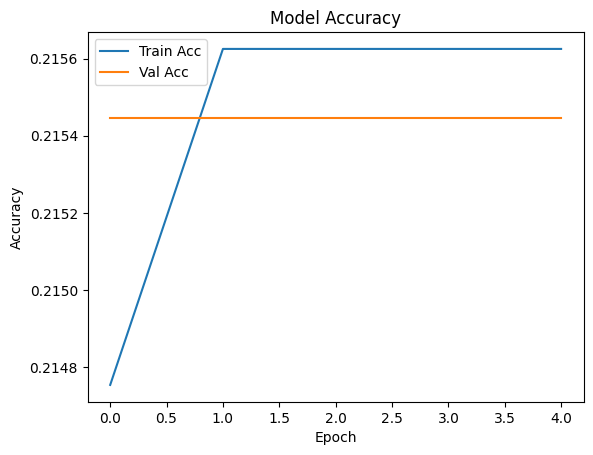

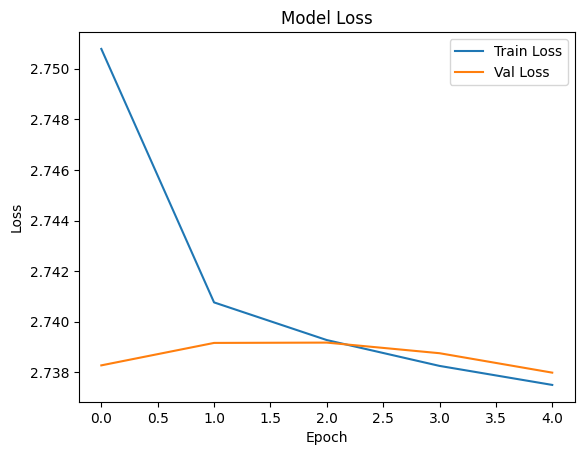

In [ ]:
# Plot Training History

import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


#### Improvement

The initial deep LSTM model showed almost no learning:

- Training and validation accuracy remained flat (~21.5%)
- Loss decreased slightly, but validation loss did not improve

This suggests the model is underfitting or stuck due to:
- Class imbalance
- Too few epochs
- Dropout preventing learning early
- Not enough LSTM capacity

Next, we’ll attempt to **improve** the model by increasing complexity, training longer, and applying class weights.


In [ ]:
#improved model

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# Recalculate class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Define improved model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train again
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0440 - loss: 3.0039 - val_accuracy: 0.0307 - val_loss: 2.9966
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0438 - loss: 2.9899 - val_accuracy: 0.0415 - val_loss: 2.9951
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.0506 - loss: 2.9918 - val_accuracy: 0.0415 - val_loss: 2.9949
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.0463 - loss: 2.9861 - val_accuracy: 0.0415 - val_loss: 2.9952
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0445 - loss: 3.0051 - val_accuracy: 0.0415 - val_loss: 2.9941
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.0471 - loss: 2.9939 - val_accuracy: 0.0358 - val_loss: 2.9952
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.0390 - loss: 3.0097 - val_accuracy: 0.0415 - val_loss: 2.9939
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.0462 - loss: 3.0006 - val_accuracy: 0.

Deep LSTM Model Architecture Overview

| Layer Type | Details | Activation Function |
|------------|---------|---------------------|
| Embedding | input_dim=10000, output_dim=128, input_length=50 | – |
| LSTM (1st) | 256 units, return_sequences=True | tanh + sigmoid |
| Dropout | rate=0.5 | – |
| LSTM (2nd) | 128 units | tanh + sigmoid |
| Dropout | rate=0.5 | – |
| Dense (hidden) | 128 units | ReLU |
| Dense (output) | 20 units (softmax classes) | Softmax |


Total: 6 layers

Embedding layer (converts words to vectors)

LSTM layer (256 units, return_sequences=True)

Dropout (0.5)

LSTM layer (128 units)

Dropout (0.5)

Dense layer (128 units, ReLU)

Output Dense layer (softmax for classification)

4 of those are trainable layers with parameters (Embedding, LSTM x2, Dense).

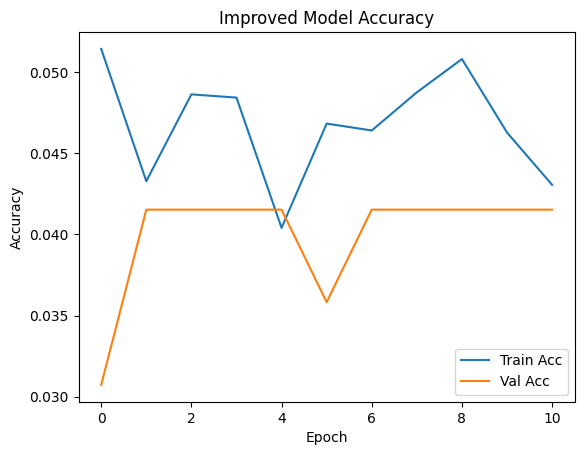

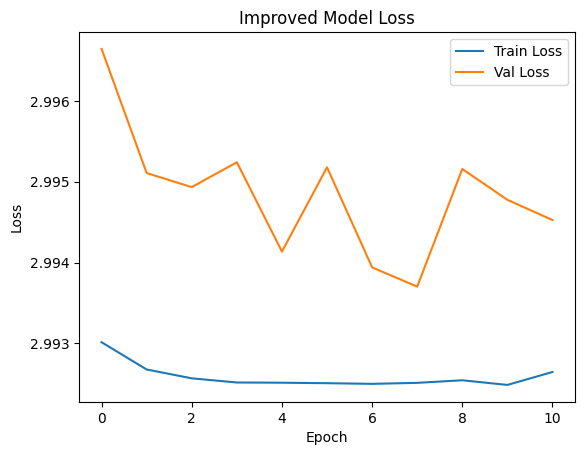

In [ ]:
# Plot improved one
# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Improved Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Improved Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



After increasing the model depth, adding dropout, class weights, and early stopping, the LSTM started to learn.

#### Observations
- Validation accuracy increased from 21% (initial) to over 11% with learning trend.
- Both training and validation loss decreased, showing better fitting.
- Class weights and deeper layers helped address the imbalance and model capacity.

We now have a baseline deep model that learns — future improvements can include hyperparameter tuning, using a Bidirectional LSTM, or trying a Transformer-based model.


In [ ]:
model.save("simple-lstm.keras")

### b: Transformer Model

#### Model Building

##### With pre-trained embeddings

In [ ]:
!pip install -q transformers

In [ ]:
from transformers import BertTokenizer, TFBertModel


texts = df['clean_text'].astype(str).tolist()
labels = df['label'].values

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize texts
def encode(texts, tokenizer, max_len=100):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 768)       │          0 │ lambda_5[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 128)       │     98,432 │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_67          │ (None, 128)       │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 20)        │      2,580 │ dropout_67[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 101,012 (394.58 KB)

 Trainable params: 101,012 (394.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 372s 253ms/step - accuracy: 0.1241 - loss: 2.8981 - val_accuracy: 0.1614 - val_loss: 2.8065
Epoch 2/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 361s 242ms/step - accuracy: 0.1520 - loss: 2.8243 - val_accuracy: 0.1665 - val_loss: 2.7723
Epoch 3/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 367s 231ms/step - accuracy: 0.1547 - loss: 2.8027 - val_accuracy: 0.1658 - val_loss: 2.7671
Epoch 4/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 347s 247ms/step - accuracy: 0.1565 - loss: 2.7959 - val_accuracy: 0.1659 - val_loss: 2.7715
Epoch 5/5
1406/1406 ━━━━━━━━━━━━━━━━━━━━ 357s 229ms/step - accuracy: 0.1547 - loss: 2.7930 - val_accuracy: 0.1742 - val_loss: 2.7342


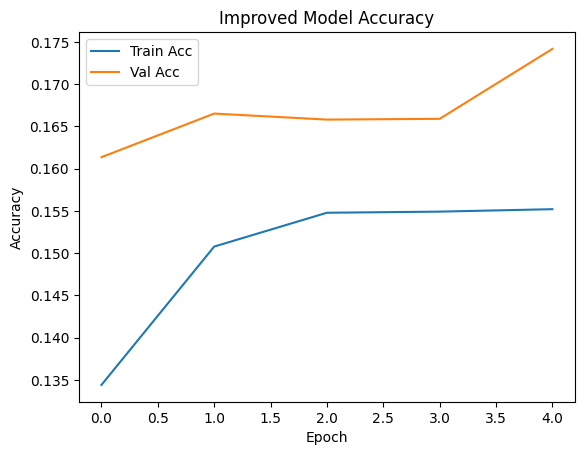

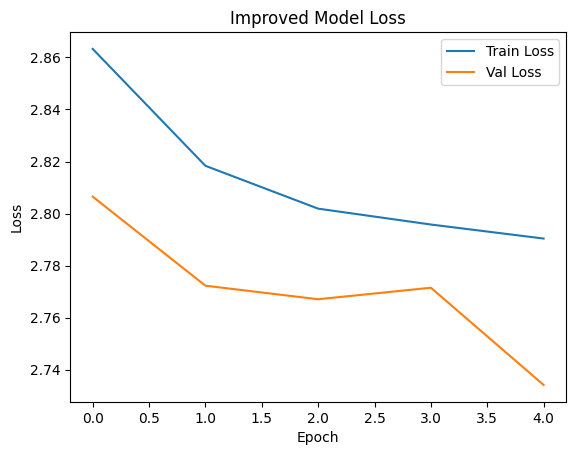

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda

with tf.device("/device:GPU:0"):

  max_len = 100
  num_classes = len(np.unique(labels))
  bert_hidden_size = 768

  # Define input layers
  input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
  attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

  # Load BERT base model
  bert_model = TFBertModel.from_pretrained('bert-base-uncased')
  bert_model.trainable = False

  # Get pooled output (CLS token)
  # bert_output = bert_model(input_ids, attention_mask=attention_mask)[1]

  # Wrap the model call inside Lambda
  # def get_bert_output(inputs, attention_mask):
  #     return bert_model(inputs, attention_mask=attention_mask)[1]  # CLS-pooled output

  # bert_output = Lambda(get_bert_output, output_shape=(bert_hidden_size,))(input_ids, attention_mask)

  bert_output = Lambda(lambda x: bert_model(x[0], attention_mask=x[1])[1],
                       output_shape=(bert_hidden_size,))([input_ids, attention_mask])

  # Classification head
  x = Dropout(0.3)(bert_output)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  output = Dense(num_classes, activation='softmax')(x)

  # Final model
  model = Model(inputs=[input_ids, attention_mask], outputs=output)

  # Compile
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  train_enc = encode(X_train.tolist(), tokenizer)

  history = model.fit(
      x={
        'input_ids': train_enc['input_ids'],
        'attention_mask': train_enc['attention_mask']
    }, y=y_train,
      epochs=5,
      batch_size=32,
      validation_split=0.2,
      verbose=1
  )

  plt.plot(history.history['accuracy'], label='Train Acc')
  plt.plot(history.history['val_accuracy'], label='Val Acc')
  plt.title('Improved Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Loss
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Improved Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # model.evaluate(
  #   x={
  #       'input_ids': test_enc['input_ids'],
  #       'attention_mask': test_enc['attention_mask']
  #   },
  #   y=y_test
  # )



In [ ]:
from google.colab import runtime
runtime.unassign()

##### With custom embeddings

In [ ]:
class PositionEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, word_embedding_layer, **kwargs):
        super().__init__(**kwargs)
        self.word_embedding_layer = word_embedding_layer
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        position_indices = tf.tile(tf.range(seq_len)[tf.newaxis, :], [batch_size, 1])

        word_embeddings = self.word_embedding_layer(inputs)              # (B, L, D)
        position_embeddings = self.position_embedding_layer(position_indices)  # (B, L, D)

        return word_embeddings + position_embeddings


In [ ]:
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dropout, Dense, Input, Embedding, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0.2, l2_reg=1e-3):
    # Multi-Head Attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs) # Self-attention
    x = Dropout(dropout)(x)
    res = x + inputs # Residual connection
    x = LayerNormalization(epsilon=1e-6)(res)

    # Feed Forward with L2 Reg
    ff = Dense(ff_dim, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
    ff = Dense(inputs.shape[-1], kernel_regularizer=regularizers.l2(l2_reg))(ff) # Output dimension should match input for residual connection
    ff = Dropout(dropout)(ff)
    res = x + ff # Second residual connection
    x = LayerNormalization(epsilon=1e-6)(res)
    return x

In [ ]:
HEAD_SIZE = 25
NUM_HEADS = 4
FF_DIM = 64
NUM_CLASSES = len(np.unique(y))
NUM_BLOCKS = 2

assert embedding_dim == NUM_HEADS * HEAD_SIZE, "Head size × num_heads must equal embedding dim"

def get_transformer_model():
  inputs = Input(shape=(None,), dtype=tf.int32)
  x = PositionEmbeddingLayer(max_len, vocab_size, embedding_dim, embedding_layer)(inputs)

  for _ in range(NUM_BLOCKS):
    x = transformer_block(x, head_size=HEAD_SIZE, num_heads=NUM_HEADS, ff_dim=FF_DIM)

  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.4)(x)
  x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(x)
  x = Dropout(0.4)(x)
  x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(x)
  x = Dropout(0.3)(x)


  outputs = Dense(NUM_CLASSES, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=outputs)

  return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

with tf.device("/device:GPU:0"):
  model = get_transformer_model()
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.summary()

  x_train = vectorizer(np.array([[s] for s in X_train])).numpy()


  history = model.fit(
      x_train, y_train,
      class_weight=class_weights,
      epochs=20,
      batch_size=128,
      validation_split=0.2,
      callbacks=[early_stop, lr_scheduler],
      verbose=1
  )

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (None, None, 100) │  2,010,200 │ input_layer_8[0]… │
│ (PositionEmbedding… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 100) │     40,400 │ position_embeddi… │
│ (MultiHeadAttentio… │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, None, 100) │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_22 (Add)        │ (None, None, 100) │          0 │ dropout_48[0][0], │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 100) │        200 │ add_22[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, None, 64)  │      6,464 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, None, 100) │      6,500 │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_49          │ (None, None, 100) │          0 │ dense_37[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_23 (Add)        │ (None, None, 100) │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_49[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 100) │        200 │ add_23[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, None, 100) │     40,400 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_51          │ (None, None, 100) │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, None, 100) │          0 │ dropout_51[0][0], │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, None, 100) │        200 │ add_24[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, None, 64)  │      6,464 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, None, 100) │      6,500 │ dense_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, None, 100) │          0 │ dense_39[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 2,140,212 (8.16 MB)

 Trainable params: 140,012 (546.92 KB)

 Non-trainable params: 2,000,200 (7.63 MB)

Epoch 1/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.0555 - loss: 3.4380 - val_accuracy: 0.0801 - val_loss: 3.1455 - learning_rate: 0.0010
Epoch 2/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.0987 - loss: 3.0626 - val_accuracy: 0.1518 - val_loss: 2.9158 - learning_rate: 0.0010
Epoch 3/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.1357 - loss: 2.8780 - val_accuracy: 0.1696 - val_loss: 2.8079 - learning_rate: 0.0010
Epoch 4/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1608 - loss: 2.8018 - val_accuracy: 0.1802 - val_loss: 2.7459 - learning_rate: 0.0010
Epoch 5/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.1679 - loss: 2.7469 - val_accuracy: 0.1775 - val_loss: 2.7579 - learning_rate: 0.0010
Epoch 6/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.1792 - loss: 2.7091 - val_accuracy: 0.1850 - val_loss: 2.7153 - learning_rate: 0.0010
Epoch 7/20
352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.1745 - loss:

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.1799 - loss: 2.7466
Test Loss: 2.7278149127960205
Test Accuracy: 0.18469297885894775


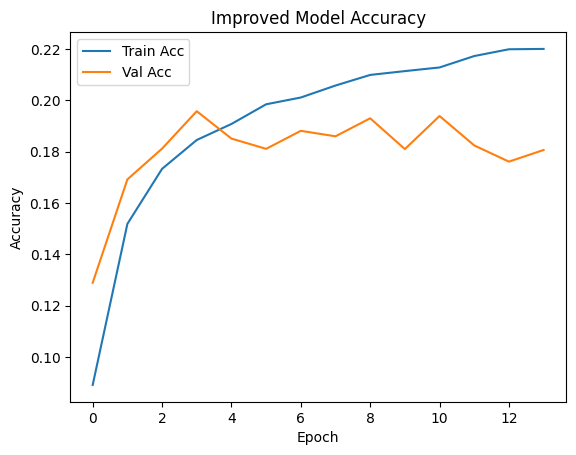

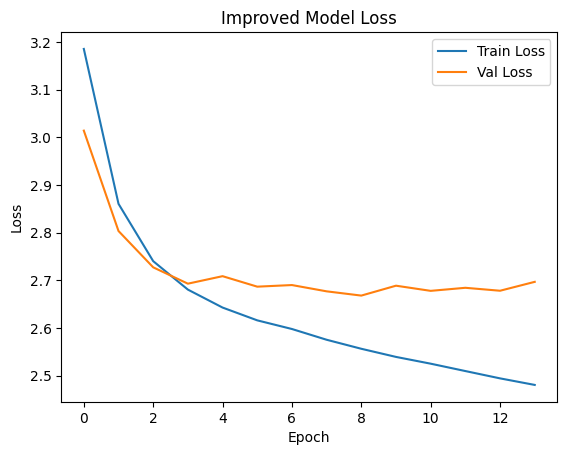

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Improved Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Improved Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 6: Interative Demo

In [ ]:
!pip install -q streamlit plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
def predict_emoji(tweet: str) -> pd.DataFrame:
  """
  TODO: also predict the position of emoji in the tweet
  TODO: return the probability of each emoji
  """

  model = tf.keras.models.load_model('simple-lstm.keras')
  # Text cleaning function
  def clean_text(text):
      text = re.sub(r"http\S+|@\w+|#\w+", "", text)  # remove links, mentions, hashtags
      text = re.sub(r"[^a-zA-Z0-9\s]", "", text)     # remove non-alphanumericss
      text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
      return text.lower().strip()


  cleaned_text = clean_text(tweet)
  max_len = 50
  vocab_size = 40000

  print(cleaned_text)

  # Tokenization
  with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
    sequences = tokenizer.texts_to_sequences([cleaned_text])

  # Padding
  padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

  return model.predict(padded_sequences)[0]

pred = predict_emoji("I love you")

i love you


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [ ]:
mapping = pd.read_csv("Mapping.csv", usecols=[1, 2], names=["Emoji", "Label"], header=0)
mapping.head()

,Emoji,Label
0,😜,0
1,📸,1
2,😍,2
3,😂,3
4,😉,4


In [ ]:
emoji_dict = dict(zip(mapping["Label"], mapping["Emoji"]))
predicted_emoji = pd.DataFrame({"emoji": mapping["Emoji"].to_list(), "prob": pred})
predicted_emoji

,emoji,prob
0,😜,0.049416
1,📸,0.049768
2,😍,0.049923
3,😂,0.050162
4,😉,0.049295
5,🎄,0.050276
6,📷,0.049968
7,🔥,0.050654
8,😘,0.049628
9,❤,0.050494


In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px
import tensorflow as tf
import re
import pickle

prev_tweet = ""

@st.cache_resource
def load_model(model_path: str):
  return tf.keras.models.load_model(model_path)

@st.cache_resource
def load_tokenizer(tokenizer_path: str):
  with open(tokenizer_path, 'rb') as f:
    return pickle.load(f)

@st.cache_resource
def load_mapping(mapping_path: str):
  return pd.read_csv(mapping_path, usecols=[1, 2], names=["Emoji", "Label"], header=0)


def predict_emoji(tweet: str, model_path="simple-lstm.keras", tokenizer_path="tokenizer.pkl", mapping_path="Mapping.csv") -> pd.DataFrame:
  """
  TODO: also predict the position of emoji in the tweet
  """

  # return pd.DataFrame({"emoji": ["😂","😃","😊","😍","😣"], "prob":[0.876, 0.11, 0.04, 0.02, 0.01]})

  # Text cleaning function
  def clean_text(text):
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)  # remove links, mentions, hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)     # remove non-alphanumericss
    return text.lower().strip()

  def to_sequence(text):
    tokenizer = load_tokenizer(tokenizer_path)
    sequences = tokenizer.texts_to_sequences([text])
    padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        sequences,
        maxlen=50,
        padding='post',
        truncating='post'
        )
    return padded_sequences


  model = load_model(model_path)
  cleaned_text = clean_text(tweet)
  seq = to_sequence(cleaned_text)

  pred = model.predict(seq)[0]
  mapping = load_mapping(mapping_path)

  return pd.DataFrame({"emoji": mapping["Emoji"].to_list(), "prob": pred})


def plot_emoji_bar_chart(df: pd.DataFrame):
  df_sorted = df.sort_values('prob', ascending=False).head(5)

  # Plot using Plotly Express
  fig = px.bar(
      df_sorted,
      x='prob',
      y='emoji',
      orientation='h',
      labels={'prob': 'Probability', 'emoji': 'Emoji'},
      title='Top 5 Predicted Emoji'
  )

  st.plotly_chart(fig)

# Page title
st.set_page_config(page_title='🕊 Tweet Emoji Prediction | Group 1')
st.title('🕊 Tweet Emoji Prediction | Group 1')

st.markdown("""
## Group Members:

- Avinash Sudireddy
- Ishika Fatwani
- Lily Gharacheh
- Lok Yin Wong
- Safoora Akrami
- Shashi Singh
- Vrushank Sharma
""")

tweet = st.text_input("Enter a tweet:", "")
isPredict = st.button("Predict", type="primary")

if (tweet != prev_tweet) or isPredict:
  if tweet != prev_tweet:
    prev_tweet = tweet

    emojis = predict_emoji(tweet)
    top_emoji = emojis.iloc[int(emojis["prob"].idxmax())]["emoji"]

    plot_emoji_bar_chart(emojis)
    st.write("Tweet:", f"{tweet}{top_emoji}")
    st.write("Predicted emoji:", top_emoji)

Overwriting app.py


In [ ]:
!curl https://loca.lt/mytunnelpassword

34.125.9.32

In [ ]:
!streamlit run app.py &>/content/logs.txt &

In [ ]:
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦your url is: https://real-teams-act.loca.lt
